In [7]:
# libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from pandas_datareader import DataReader as wb
from scipy.stats import linregress
from dateutil.relativedelta import relativedelta

In [8]:
# Get market data
start = dt.datetime.now() - relativedelta(years=5)
end = dt.datetime.now()
tickers = {'stock': 'MSFT', 'bench': '^GSPC'}
stock = wb([tickers['stock']],'yahoo',start,end)['Close']
bench = wb([tickers['bench']],'yahoo',start,end)['Close']

In [9]:
def synsynchronize_returns(df1, df2):
    col = list(df1.columns) + list(df2.columns)
    df1 = df1.pct_change().dropna()
    df2 = df2.pct_change().dropna()
    #Synchronise timetamps
    df1['Date'] = df1.index
    df1 = df1.reset_index(drop=True)
    df2['Date'] = df2.index
    df2 = df2.reset_index(drop=True)
    timestamps_1 = list(df1['Date'].values)
    timestamps_2 = list(df2['Date'].values)
    timetamps = list(set(timestamps_1) & set(timestamps_2))
    #Synchronise timeseries for benchmark
    df1_sync = df1[df1['Date'].isin(timetamps)]
    df1_sync.sort_values(by = 'Date', ascending = True)
    df1_sync = df1_sync.reset_index(drop = True)
    #Synchronise timeseries for asset
    df2_sync = df2[df2['Date'].isin(timetamps)]
    df2_sync.sort_values(by = 'Date', ascending = True)
    df2_sync = df2_sync.reset_index(drop = True)
    #Table for security and benchmark
    df = pd.merge(df1_sync,df2_sync, on='Date')
    df = df[['Date'] + col]
    return df

df = synsynchronize_returns(stock,bench)
print(df.head(7))

Symbols       Date      MSFT     ^GSPC
0       2016-10-20 -0.004867 -0.001376
1       2016-10-21  0.042096 -0.000084
2       2016-10-24  0.022461  0.004750
3       2016-10-25 -0.000164 -0.003798
4       2016-10-26 -0.005903 -0.001740
5       2016-10-27 -0.008742 -0.002987
6       2016-10-28 -0.003827 -0.003108


In [10]:
# Linear regression
y = df[tickers['stock']].values
x = df[tickers['bench']].values
reg = linregress(x,y)
beta = np.round(reg.slope,3)
alpha = np.round(reg.intercept,3)
r2 = np.round(reg.rvalue**2,3)
pvalue = reg.pvalue
null_hypoth = pvalue > 0.05

In [11]:
# Regresion result
reg_result = 'Linear Regression of ' + str(tickers['stock']) + ' versus ' + str(tickers['bench'] + '\n')\
        + 'Beta:     ' + str(beta) + '\n'\
        + 'Alpha:    ' + str(alpha) + '\n'\
        + 'R^2:      '  + str(r2) + '\n'\
        + 'P-Value:  ' + str(pvalue) + '\n'\
        + 'Null Hypothesis is ' + str(null_hypoth)

print(reg_result)

Linear Regression of MSFT versus ^GSPC
Beta:     1.194
Alpha:    0.001
R^2:      0.694
P-Value:  0.0
Null Hypothesis is False


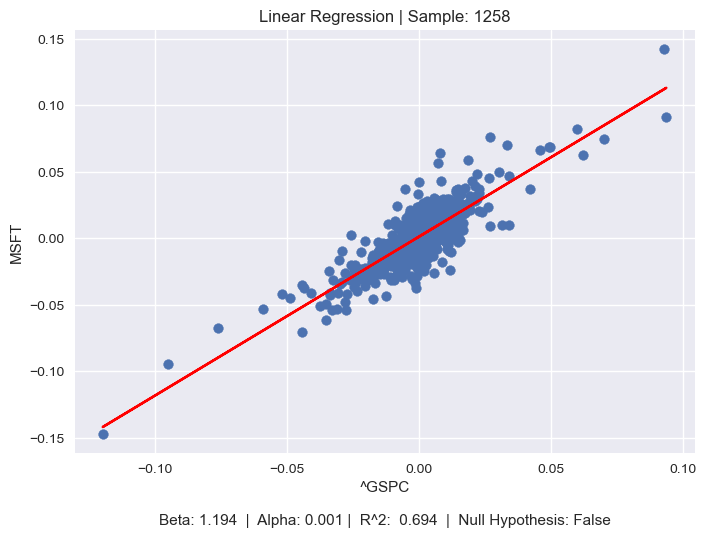

In [12]:
# Plot Regression
predictor = alpha + beta * x
plt.figure()
plt.title('Linear Regression | Sample: ' + str(len(x)))
plt.scatter(x,y)
plt.style.use('seaborn')
plt.ylabel(tickers['stock'])
plt.xlabel(
    tickers['bench'] + '\n' + '\n'\
    + 'Beta: ' + str(beta) + '  |  Alpha: ' + str(alpha)\
    + ' |  R^2:  ' + str(r2) + '  |  Null Hypothesis: ' + str(null_hypoth)
)
plt.plot(x, predictor, color = 'red')
plt.show()